<h1 align="center">
<img src="https://drive.google.com/uc?export=view&id=1_ZkE3dnYg9KykzdZE6lIK2s_q_nbiKk_" width="160" height="160">
</h1>
<h1 align="center"> Reinforcement Learning - 40957</h1>
<h3 align="center">Dr. Rohban, Mr. Hasani</h3>
<h5 align="center">Sharif University of Technology<br/>Computer Engineering Department<br/>  Spring 2023</h5>

---

# Homework 01
<h3 align="center"><b>Vahid Pourakbar 400205511</b></h3>

# Question 6 - CartPole
---

# Installations and Imports

In [ ]:
!sudo apt-get update
!pip install 'imageio==2.4.0'
!sudo apt-get install -y xvfb ffmpeg
!pip3 install gymnasium[classic_control]

In [2]:
import math
import base64
import random
import imageio
import IPython
import matplotlib
import gymnasium as gym
from itertools import count
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

# Utility functions for rendering evironment

In [4]:
def embed_mp4(filename):
  
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    
    return IPython.display.HTML(tag)

In [5]:
def create_policy_eval_video(env, policy, filename, num_episodes=1, fps=30):
  
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(DEVICE)
                action = policy(state)
                state, reward, terminated, truncated, _ = env.step(action.item())
                video.append_data(env.render())
                if terminated:
                    break
    return embed_mp4(filename)

# Replay Memory and Q-Network

In [6]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
# Complete the Q-Network below. 
# The Q-Network takes a state as input and the output is a vector so that each element is the q-value for an action.

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # ==================================== Your Code (Begin) ====================================
        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_observations, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(128, n_actions))
        # ==================================== Your Code (End) ====================================

    def forward(self, x):
        # ==================================== Your Code (Begin) ====================================
        return self.net(x)
        # ==================================== Your Code (End) ====================================

# Policies

Now we define 2 policies. We use greedy policy for evaluation and e-greedy during training.

In [41]:
# This function takes in a state and returns the best action according to your q-network.
# Don't forget "torch.no_grad()". We don't want gradient flowing through our network. 
import numpy as np

# state shape: (1, state_size) -> output shape: (1, 1)  
def greedy_policy(qnet, state):
    # ==================================== Your Code (Begin) ====================================
    state = state.to(DEVICE)
    with torch.no_grad():
      return qnet(state).argmax().view(-1, 1)
    # ==================================== Your Code (End) ====================================

In [42]:
# state shape: (1, state_size) -> output shape: (1, 1)
# Don't forget "torch.no_grad()". We don't want gradient flowing through our network.

def e_greedy_policy(qnet, state, current_timestep):
    
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * current_timestep / EPS_DECAY)
    # ==================================== Your Code (Begin) ====================================
    # With probability "eps_threshold" choose a random action 
    # and with probability 1-"eps_threshold" choose the best action according to your Q-Network.
    if random.random() <= eps_threshold:
        return torch.tensor(env.action_space.sample(), dtype=torch.long, device=DEVICE).view(-1, 1)
    else:
        return greedy_policy(qnet, state)
    # ==================================== Your Code (End) ====================================

# Initial setup

In [43]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v1", render_mode='rgb_array')
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
q_network = DQN(n_observations, n_actions).to(device)
target_network = DQN(n_observations, n_actions).to(device)
optimizer = optim.Adam(q_network.parameters(), lr=LR)
memory = ReplayMemory(10000)

create_policy_eval_video(env, lambda s: greedy_policy(q_network, s), "random_agent")

# Training

100%|██████████| 600/600 [08:51<00:00,  1.13it/s]

Complete


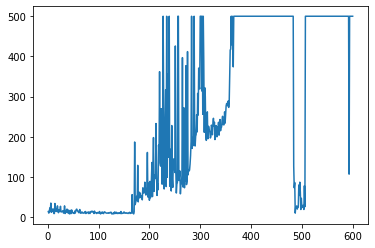

In [44]:
from tqdm import tqdm
import numpy as np

SASR = namedtuple('SASR', ('state', 'action', 'next_state', 'reward'))

num_episodes = 600
episode_returns = []
episode_durations = []
t = 0   

for i_episode in tqdm(range(num_episodes)):
    
    # ==================================== Your Code (Begin) ====================================
    # 1. Start a new episode
    # 2. Run the environment for 1 step using e-greedy policy
    # 3. Add the (state, action, next_state, reward) to replay memory
    # 4. Optimize your q_network for 1 iteration
    #       4.1 Sample one batch from replay memory
    #       4.2 Compute predicted state-action values using q_network
    #       4.3 Compute expected state-action values using target_network (Don't forget "no_grad" because we don't want gradient through target_network)
    #       4.4 Compute loss function and optimize q_network for 1 step
    # 5. Soft update the weights of target_network
    #       θ′ ← τ θ + (1 −τ )θ′
    #       θ   is q_network weights
    #       θ′  is target_network weights            
    # 6. Keep track of the total reward for each episode to plot later
    
    # ========= 1
    episode_returns.append(0)
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)   
    i = 0
    done = False

    # ========= 2
    while not done:
        action = e_greedy_policy(q_network, state, t)
        t += 1
        obv, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
 
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(obv, dtype=torch.float32, device=device).unsqueeze(0)
        reward = torch.tensor([reward], device=device)

    # ========= 3
        memory.push(SASR(state, action, next_state, reward))
        state = next_state

    # ========= 4
        if len(memory) > 500:
            samples = memory.sample(BATCH_SIZE)
            batch = SASR(*zip(*samples))
            mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
            non_final_next_states = torch.cat([ns for ns in batch.next_state if ns is not None])
            states_batch = torch.cat(batch.state)
            actions_batch = torch.cat(batch.action)
            rewards_batch = torch.cat(batch.reward)

            y_value = q_network(states_batch).gather(1, actions_batch)
            next_state_values = torch.zeros(BATCH_SIZE, device=device)
            with torch.no_grad():
                next_state_values[mask] = target_network(non_final_next_states).max(1)[0]
            y_target_value = (next_state_values * GAMMA) + rewards_batch

            criterion = nn.MSELoss()
            loss = criterion(y_value, y_target_value.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(q_network.parameters(), 100)
            optimizer.step()
    
    # ========= 5
        theta_prime = target_network.state_dict()
        theta = q_network.state_dict()
        for key in theta:
            theta_prime[key] = TAU*theta[key] + (1-TAU)*theta_prime[key]
        target_network.load_state_dict(theta_prime)           

    # ========= 6
        episode_returns[i_episode] += (GAMMA**i) * reward.item()
        i += 1

        if done:
            episode_durations.append(i)
    # ==================================== Your Code (End) ====================================  

print('Complete')
plt.plot(range(1, num_episodes+1), episode_durations)

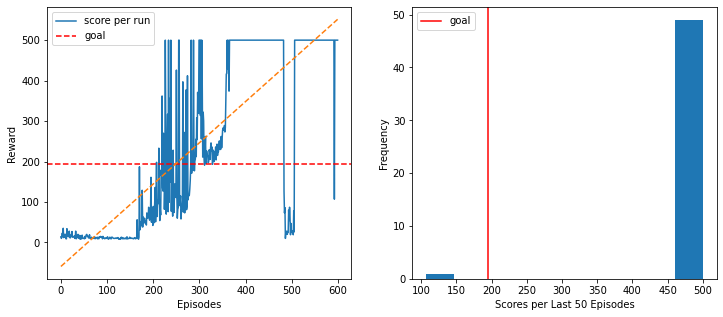

In [45]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    # clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

plot_res(episode_durations)

In [46]:
# Render trained model

create_policy_eval_video(env, lambda s: greedy_policy(q_network, s), "trained_agent")